# DT recovering

## Content

* [Task](#Task)
* [Dataset](#Dataset)
* [Model architecture](#Architecture)
* [Training](#Training)
* [Inference](#Inference)

## Task

Recover DT logs on the basis of known measurements

## Dataset


Logs from one place were used to train and estimate the model.

We choose the set of 17 logs measured for 70% of wells (90 wells) with known 'DT' in the place: 'CILD', 'GR', 'GZ1', 'GZ2', 'GZ3', 'GZ4', 'GZ5', 'LLD', 'MINV', 'MNOR', 'MSFL', 'NKTD', 'NKTR', 'PHIT', 'PRON', 'RT', 'SP'. This dataset can be represented as an array of 1d multichannel arrays of shape `[17, length]`, each array has a different length. The dataset was split into train and test in proportion 80:20.

In [1]:
import os
import sys
import pickle

sys.path.insert(0, os.path.join("..", "..", ".."))

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from petroflow import WellLogsDataset
from petroflow.batchflow import Pipeline, B, V
from petroflow.batchflow.models.torch import UNet

In [3]:
LOGS = ('CILD', 'DT', 'GR', 'GZ1', 'GZ2', 'GZ3', 'GZ4', 'GZ5', 'LLD', 'MINV', 'MNOR', 'MSFL',
 'NKTD', 'NKTR', 'PHIT', 'PRON', 'RT', 'SP')

In [4]:
WELL_NPZ_PATH = "/notebooks/data/well_logs/npz/*" # all files must contain logs described by LOGS
ds = WellLogsDataset(path=WELL_NPZ_PATH, no_ext=True, sort=True)
ds.split(0.8, shuffle=42)

## Architecture

To train the model we use U-Net.

Model was trained on crops of size 256. Loss for the model is MSE.

Configuration of the model:
* input shape - [256, 17]
* output shape - [256, 1]
* filters in decoder and encoder - [64, 128, 256, 512, 1024].

In [5]:
CROP_SIZE = 128

model_config = {
    'device': 'cuda:3',
    'initial_block/inputs': 'x',
    'inputs/x': {'shape': [len(LOGS)-1, CROP_SIZE]},
    'inputs/y': {'shape': [1, CROP_SIZE]},
    "head/num_classes": 1,
    'loss': 'mse'
}

## Training

In [6]:
N_EPOCH = 200
BATCH_SIZE = 32

In [7]:
def concatenate_batch(batch, model, concat_mask=True):
    logs = np.concatenate(batch.logs).astype('float32')
    feed_dict = {"inputs": logs}
    if concat_mask:
        feed_dict["targets"] = np.concatenate(batch.dt).astype('float32')
    return feed_dict

All the training process is described in pipeline

In [8]:
template_train_ppl = (Pipeline()
    .load(fmt="npz", components=["dept", "logs"])
    .init_variable('loss', default=[])
    .keep_channels(tuple(LOGS))
    .drop_nans()
    .add_components("dt", B("array_of_nones"))
    .norm_mean_std(components="logs")
    .split_by_mnemonics(mnemonics=['DT'], component_from='logs', component_to='dt')
    .random_crop(CROP_SIZE, n_crops=4, components=["logs", "dt"])
    .init_model('dynamic', UNet, 'model', model_config)
    .train_model('model', make_data=concatenate_batch, fetches='loss',
                 save_to=V('loss'), mode='a')
    .run(batch_size=BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True,
         lazy=True, bar=True)
)

In [9]:
train_ppl = (ds.train >> template_train_ppl)
b = train_ppl.run()

100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


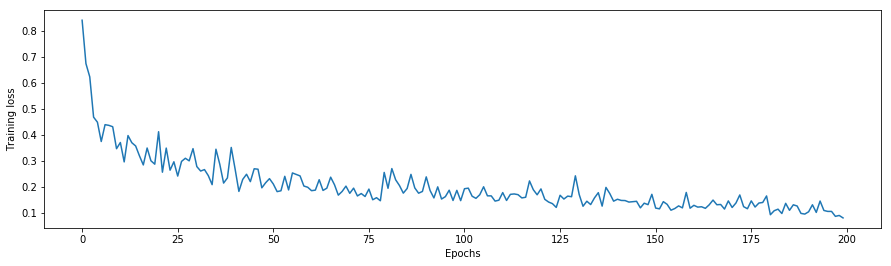

In [10]:
train_loss = [np.mean(l) for l in np.array_split(train_ppl.get_variable("loss"), N_EPOCH)]

fig = plt.figure(figsize=(15, 4))
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

Here we can see that learning process converged.

## Inference

To check the quality of the algorithm we plot some examples of recovered logs.

In [11]:
template_test_ppl = (Pipeline()
    .load(fmt="npz", components=["dept", "logs"])
    .init_variable('output', default=[])
    .init_variable('input', default=[])
    .keep_channels(tuple(LOGS))
    .drop_nans()
    .add_components("dt", B("array_of_nones"))
    .norm_mean_std(components="logs")
    .split_by_mnemonics(mnemonics=['DT'], component_from='logs', component_to='dt')
    .random_crop(CROP_SIZE, n_crops=4, components=["logs", "dt"])
    .import_model('model', train_ppl)
    .predict_model('model', make_data=concatenate_batch, fetches='predictions',
                   save_to=V('output'), mode='w')
    .update_variable('input', [B('logs'), B('dt'), B('meta')], mode='w')
    .run(batch_size=10 * BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True, lazy=True)
)

In [12]:
test_ppl = (ds.test >> template_test_ppl)
test_ppl.next_batch()

In [13]:
logs, target, meta =  test_ppl.get_variable('input')

logs = np.concatenate(logs)
target = np.concatenate(target)
output = test_ppl.get_variable('output')

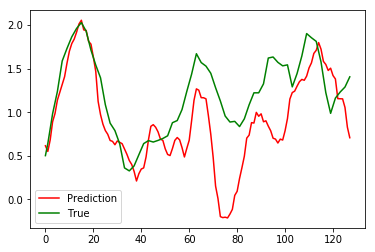

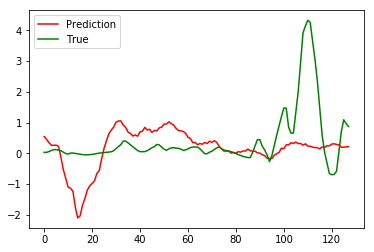

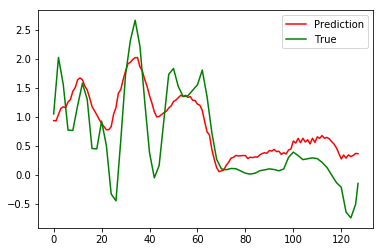

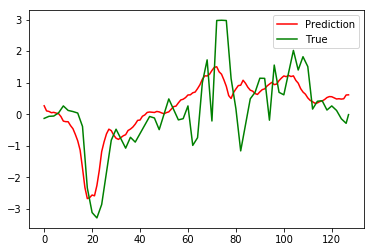

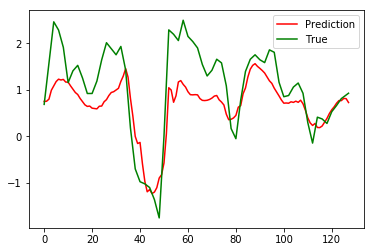

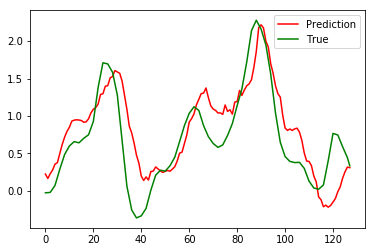

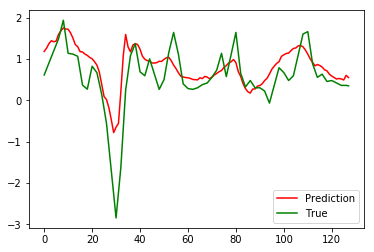

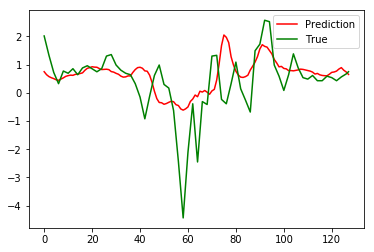

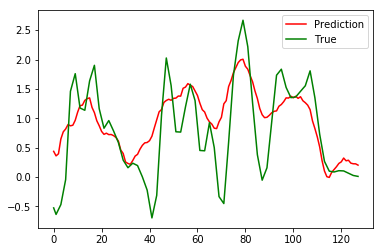

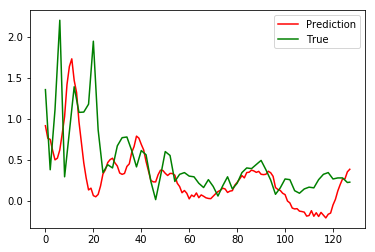

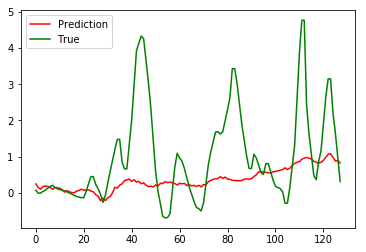

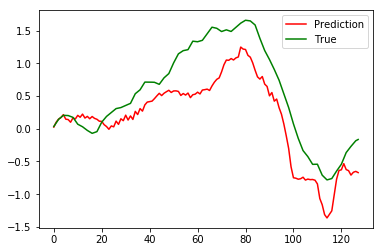

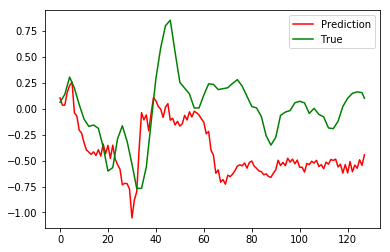

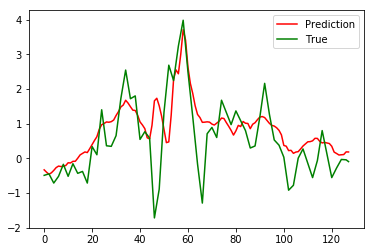

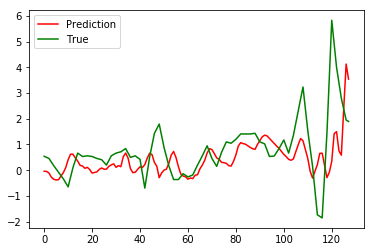

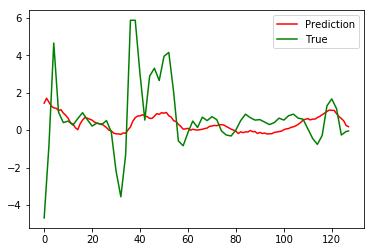

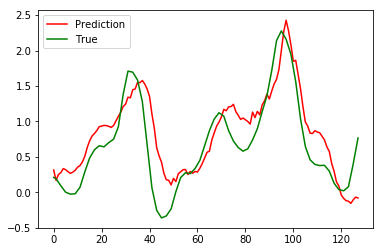

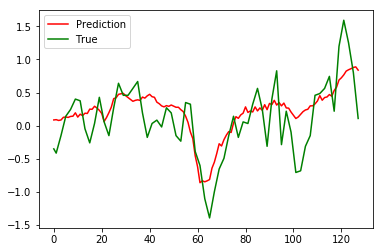

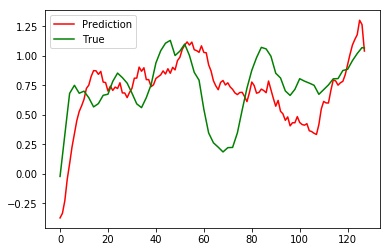

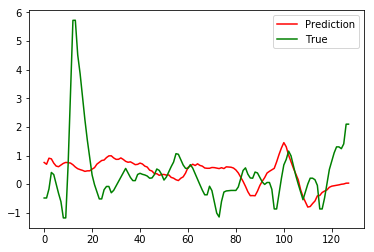

In [14]:
FULL_SET = LOGS#np.array(['CFTC', 'CILD', 'GR', 'GZ1', 'GZ2', 'GZ3', 'GZ4', 'GZ7', 'LLD', 'NKTD', 'PROX', 'SP'])

n_crops = 20

#plt.figure(figsize=(5 * n_crops, 50))

non_const = [np.median(s[0]) > 0 for s in target]

target = target[non_const]
output = output[non_const]
random_indices = np.random.choice(range(len(target)), n_crops, replace=False)

for j, crop in enumerate(random_indices):
    plt.plot(output[crop, 0], color='r', label='Prediction')
    plt.plot(target[crop, 0], color='g', label='True')
    plt.legend()
    plt.show()